# The PyBaMM Solvers

PyBaMM has a few different solvers that can be used to solve the model equations. In this notebook we will go through the different solvers and contrast their features and performance.


In [1]:
import pybamm
import numpy as np
import time
import matplotlib.pyplot as plt


The solvers available in PyBaMM are:

- [`pybamm.CasadiSolver`](https://docs.pybamm.org/en/stable/source/api/solvers/casadi_solver.html): This is a wrapper around the CasADi solver, which is a wrapper around the [Sundials solver suite](https://sundials.readthedocs.io/en/latest/). This has been the default solver in PyBaMM since its inception, but it will soon be replaced as the default solver by the `IDAKLUSolver` described below.
- [`pybamm.IDAKLUSolver`](https://docs.pybamm.org/en/stable/source/api/solvers/idaklu_solver.html): This is a direct wrapper around the Sundials IDAS solver written by the PyBaMM team. This has been customised to work well with PyBaMM's models and will soon be the default solver in PyBaMM. It is often faster than the `CasadiSolver` with default model options, but the `CasadiSolver` can still be faster for some models with custom options so it is worth trying both.
- [`pybamm.ScipySolver`](https://docs.pybamm.org/en/stable/source/api/solvers/scipy_solver.html): This is a wrapper around the `scipy.integrate.solve_ivp` solver. This is generally much slower than the other solvers and is only recommended for very simple problems or for testing.
- [`pybamm.IDAKLUJax`](https://docs.pybamm.org/en/stable/source/api/solvers/idaklu_jax.html) (*experimental*): This is a [JAX](https://jax.readthedocs.io/en/latest/index.html) wrapper around the `pybamm.IDAKLUSolver` solver that allows it to be used within a JAX model. This is still experimental for Windows, so is only recommended for use on Linux or MacOS.
- [`pybamm.JaxSolver`](https://docs.pybamm.org/en/stable/source/api/solvers/jax_solver.html) (*experimental*): This is a pure JAX solver that uses the `jax` library to solve the model equations instead of the Sundials solvers. This is also experimental on Windows, so is only recommended for use on Linux or MacOS.

The two main solvers are the Casadi and IDAKLU solvers. Out of these two, the IDAKLU solver is generally recommended as it is faster and has more features. Historically, the Casadi solver has been the default solver in PyBaMM, but current development is focused on the IDAKLU solver and this is expected to become the default solver in the near future.

## Solver features

- **Speed**: The IDAKLU solver is generally faster than the Casadi solver, both for solving models and also post-processing the ouput variables. However, for some physics options the Casadi solver can be faster, so it is worth trying both.
- **Sensitivity analysis**: The IDAKLU solver can compute forward model sensitivities with respect to input parameters. It uses the Sundials IDAS solver to compute the sensitivities. The Casadi solver can also compute sensitivities, but it is generally slower than the IDAKLU solver and not recommended for this purpose.
- **Adjoint sensitivity analysis**: Either adjoint sensitivity analysis or reverse-mode auto differentiation is useful to compute sensitivities if the number of input parameters is very large (e.g. ML models). Currently only the pure Jax solver supports reverse mode auto differentiation, but adding adjoint sensitivity analysis to the IDAKLU solver is a future development goal.
- **Parallism**: If a list of input parameters are passed to the solver, the IDAKLU solver can solve the model in parallel for each parameter using multiple threads via OpenMP. This can be useful, for example for parameter sweeps. The Casadi solver can also solve models in parallel, but it uses the Python `multiprocessing` library which can be slower than OpenMP. If enough threads are available and the model is large enough, the IDAKLU solver can also parallelise a single solve using OpenMP and the Sundials NVECTOR_OPENMP implementation.
- **GPU acceleration**: Currently only the pure Jax solver supports GPU acceleration. We have some experimental support for GPU acceleration via a new JAX-based backend for the IDAKLU solver, but this is still in development.
- **Events**: The Casadi, IDAKLU and Scipy solvers all support events, which are used to trigger an action when a certain condition is met. The main use case for events is to stop the solver between different steps of an experiment. The pure Jax solver does not support events. The IDAKLU solver has a faster and more robust event handling than the Casadi solver, as it uses the underlying Sundials event handling.
- **Evaluation and interpolation points**: All the solver take a list of time points to evaluate the solution (the `t_eval` argument). This stops the solver at each requested time point, slowing down the time-stepping of the solver. The IDAKLU solver can also take a list of interpolation points (the `t_interp` argument) which will interpolate the solution at these points without stopping the solver, speeding up the calculation of the solution.
- **other features**: The Sundials solvers have many custom features that change the way the solver works (e.g. tolerances, linear solvers, minimum step sizes, etc.), you can read more about these in the [Sundials docs](https://sundials.readthedocs.io/en/latest/). Some of these are exposed in the Casadi solver (see the `extra_options` arguments to this solver), but the IDAKLU solver has generally more features exposed and documented (see the [docs](https://docs.pybamm.org/en/stable/source/api/solvers/idaklu_solver.html)). If PyBaMM does not expose a feature you need, you can always post an issue on the [GitHub page](https://github.com/pybamm-team/PyBaMM/issues) and we will try to add it.

## Solver Comparison

Below we will compare three of the main solvers available in PyBaMM: the Casadi, IDAKLU and Scipy solvers. We will compare the speed of the solvers for solving the SPM, SPMe and DFN models with their default options, and compare the result.

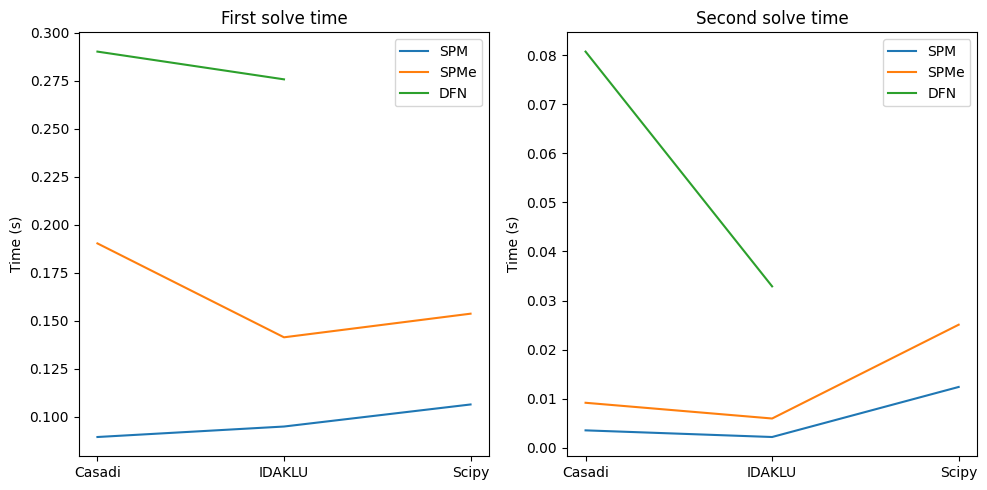

In [2]:
first_solve_time = np.zeros((3, 3))
second_solve_time = np.zeros((3, 3))
for i, model_cls in enumerate(
    [pybamm.lithium_ion.SPM, pybamm.lithium_ion.SPMe, pybamm.lithium_ion.DFN]
):
    for j, solver_cls in enumerate(
        [pybamm.CasadiSolver, pybamm.IDAKLUSolver, pybamm.ScipySolver]
    ):
        if solver_cls == pybamm.ScipySolver and model_cls == pybamm.lithium_ion.DFN:
            first_solve_time[i, j] = np.nan
            second_solve_time[i, j] = np.nan
            continue
        sim = pybamm.Simulation(model_cls(), solver=solver_cls())
        start_time = time.perf_counter()
        sol = sim.solve([0, 3600])
        voltage = sol["Terminal voltage [V]"](0)
        end_time = time.perf_counter()
        first_solve_time[i, j] = end_time - start_time
        start_time = time.perf_counter()
        sol = sim.solve([0, 3600])
        voltage = sol["Terminal voltage [V]"](0)
        end_time = time.perf_counter()
        second_solve_time[i, j] = end_time - start_time


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, model_cls in enumerate(
    [pybamm.lithium_ion.SPM, pybamm.lithium_ion.SPMe, pybamm.lithium_ion.DFN]
):
    ax[0].plot(first_solve_time[i, :], label=model_cls.__name__)
    ax[1].plot(second_solve_time[i, :], label=model_cls.__name__)
ax[0].set_xticks(np.arange(3))
ax[0].set_xticklabels(["Casadi", "IDAKLU", "Scipy"])
ax[0].set_ylabel("Time (s)")
ax[0].set_title("First solve time")
ax[0].legend()
ax[1].set_xticks(np.arange(3))
ax[1].set_xticklabels(["Casadi", "IDAKLU", "Scipy"])
ax[1].set_ylabel("Time (s)")
ax[1].set_title("Second solve time")
ax[1].legend()
plt.tight_layout()
plt.show()

The "First solve time" plot includes the setup time for the solver, which for this relativly small problem is significant. However, even for this plot it is clear that the IDAKLU solver is faster than the other two solvers. 

The "Second solve time" plot excludes this setup time and is a clearer indication of the relative speed of the solvers for (a) calculating a solution and (b) post-processing the solution to extract the voltage. 

The Scipy solver is much slower than the other two solvers as it is a Python solver and not optimised for speed. Both the Casadi and IDAKLU solvers use the same Sundials solvers under the hood, but the IDAKLU solver is generally faster as it has been customised to work well with PyBaMM's models. The IDAKLU solver also has improved online (via `t_eval`) or post-processing interpolation features, so obtaining output variables can often be faster than the Casadi solver.